# Proyecto Final - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

Analizando la situación que se presentó en el Proyecto 3, el medio de pago EFECTIVO ha disminuido en el transcurso de los años y se a incrementado el pago a traves de TELEPASE. También en la investigación se pudo enferir que en marzo 2018, la decisión de una politica de aumento de precio de la tarifa del peaje y descuento para quienes pagaran por "TELEPASE" influyó considerablemente en el comportamiento de los ciudadanos. Entonces, resulta importante ahondar en esta linea ya que el impacto económico de una decisión en relación al medio de pago puede ser significativo.

Esto sigue una tendencia de digitalización de los procesos a la que se estan adaptando las organizaciones brindado mas opciones a la hora de realizar una transacción con el cliente y además implican menor costo operativo. Es por eso que la elección del medio de pagos adecuado es uno de los aspectos más importantes que los negocios deben considerar.

Para esta ocasión se tendran en cuenta las bases de 2017, 2018 y 2019 del flujo Vehicular de Buenos Aires, todos los medios de pago posibles y la incorporación de los días feriados como variable adicional.

Preguntas:

1- ¿Cómo varían las formas de pago en todas las estaciones de peaje? Considerando que en Illia el pago en efectivo se vió disminuido en el tiempo (Proyecto 3) se considera oportuno revisar esta variable en todas las bases presentadas. Las formas de pago pueden influir en las decisiones de contratación y capacitación del personal que atiende en el peaje así también como los procesos logisticos de retiro de caudales, seguridad, entre otros.

2- ¿Hay comportamientos de pago distintos si es día feriado o fines de semana? Este análisis podria dilusidar la posibilidad de cambiar las formas de pago aceptadas en estos días particulamente y eficientizar los recursos.

Inicialmente se hará un Análisis Exploratorio de Datos ya que puede diferir con lo realizado en el proyecto anterior que solo nos focalizamos en la estación Illia y medio de pago EFECTIVO.

Luego se hara un nuevo modelo de Árbol de decisión para considerar mas variables en la predicción del tráfico para el último trimestre del año 2019. Esto se planteo como anternativa en el Proyecto 3, como algo a probar para obtener una mejor performance. Se tendrá en cuenta el mejor RMSE obtenido con el modelo SARIMAX Optimizado (5139.25) pero tambien se abordara un modelo bench para este análisis que integra a las distintas estaciones de peaje. Para esta opotunidad no se integra a la base 2020 porque el inicio de la pandemia altero las condiciones normales del flujo vehicular.



### Análisis Exploratorio de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import plotly
from plotly.offline import plot
import plotly.express as px
import seaborn as sns

In [2]:
#Se importan las bases a utilizar
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [3]:
#Se agrupa en una sola
dataset = pd.concat([data_2019, data_2018, data_2017])
dataset.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
#Se investiga que valores toman los campos estacion, sentido, tipo_vehiculo, día y forma_pago.
print(dataset['estacion'].unique())
print(dataset['sentido'].unique())
print(dataset['tipo_vehiculo'].unique())
print(dataset['forma_pago'].unique())
print(dataset['dia'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB' 'Alberdi' 'Dellepiane Centro' 'Dellepiane Liniers']
['Centro' 'Provincia']
['Liviano' 'Pesado']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD' 'TARJETA DISCAPACIDAD' 'MONEDERO' 'Otros']
['Martes' 'Viernes' 'Lunes' 'Miércoles' 'Sábado' 'Jueves' 'Domingo']


In [5]:
#Se corrije Alberdi y se unifica Dellepiane
dataset = dataset.replace({'Dellepiane Centro':'Dellepiane', 'Dellepiane Liniers':'Dellepiane', 'Alberti':'Alberdi'})

#Se unifica Tarjeta Discapacidad
dataset = dataset.replace("T. DISCAPACIDAD","TARJETA DISCAPACIDAD")

#Para facilitar los análisis, se colocará un número al frente del día de semana
dataset = dataset.replace("Lunes"    , "1 Lunes"    )
dataset = dataset.replace("Martes"   , "2 Martes"   )
dataset = dataset.replace("Miércoles", "3 Miercoles")
dataset = dataset.replace("Jueves"   , "4 Jueves"   )
dataset = dataset.replace("Viernes"  , "5 Viernes"  )
dataset = dataset.replace("Sábado"   , "6 Sabado"   )
dataset = dataset.replace("Domingo"  , "7 Domingo"  )

#Se cambia el nombre de la columna que contiene el día de la semana
dataset.rename(columns = {'dia':'dia_sem'}, inplace = True) 

In [6]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,periodo,hora_inicio,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2019,0,2 Martes,Alberdi,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00
1,2019,0,2 Martes,Alberdi,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00
2,2019,0,2 Martes,Alberdi,Provincia,Liviano,NO COBRADO,53,2019-01-01 01:00:00
3,2019,0,2 Martes,Alberdi,Provincia,Liviano,TELEPASE,18,2019-01-01 01:00:00
4,2019,0,2 Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01 01:00:00


In [7]:
#Tambien eliminamos la columna hora_inicio y periodo
dataset.drop(columns=['hora_inicio','periodo'], inplace = True)

#Reordenamos por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head()

,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,7 Domingo,Dellepiane,Centro,Liviano,NO COBRADO,6,2017-01-01
1,7 Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01
2,7 Domingo,Illia,Provincia,Liviano,NO COBRADO,3,2017-01-01
3,7 Domingo,Dellepiane,Provincia,Liviano,INFRACCION,3,2017-01-01
4,7 Domingo,Avellaneda,Centro,Liviano,NO COBRADO,36,2017-01-01


In [8]:
#Se agrega variables nuevas al dataset
dataset["año"] = dataset["fecha"].dt.year
dataset["trimestre"] = dataset["fecha"].dt.quarter
dataset["mes"] = dataset["fecha"].dt.month
dataset["dia"] = dataset["fecha"].dt.day
dataset["hora"] = dataset["fecha"].dt.hour
dataset

,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,año,trimestre,mes,dia,hora
0,7 Domingo,Dellepiane,Centro,Liviano,NO COBRADO,6,2017-01-01 00:00:00,2017,1,1,1,0
1,7 Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01 00:00:00,2017,1,1,1,0
2,7 Domingo,Illia,Provincia,Liviano,NO COBRADO,3,2017-01-01 00:00:00,2017,1,1,1,0
3,7 Domingo,Dellepiane,Provincia,Liviano,INFRACCION,3,2017-01-01 00:00:00,2017,1,1,1,0
4,7 Domingo,Avellaneda,Centro,Liviano,NO COBRADO,36,2017-01-01 00:00:00,2017,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3560701,2 Martes,Dellepiane,Provincia,Pesado,TELEPASE,13,2019-12-31 23:00:00,2019,4,12,31,23
3560702,2 Martes,Dellepiane,Provincia,Pesado,NO COBRADO,1,2019-12-31 23:00:00,2019,4,12,31,23
3560703,2 Martes,Dellepiane,Provincia,Pesado,EXENTO,2,2019-12-31 23:00:00,2019,4,12,31,23
3560704,2 Martes,Dellepiane,Provincia,Liviano,TELEPASE,150,2019-12-31 23:00:00,2019,4,12,31,23


In [9]:
#Exportamos en csv el dataset para acceder facilmente a el
dataset.to_csv('dataset_proyecto_final.csv')

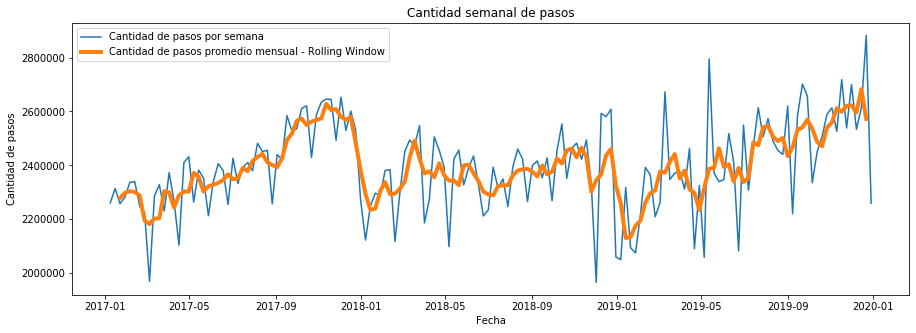

In [10]:
#Resampleamos semanalmente el dataset para graficar y ver el comportamiento
semanal = dataset.resample('W', on = 'fecha').sum()
semanal.drop(columns = ["año","trimestre", "mes", "dia", "hora"], inplace = True)

#Se elimina la primer y última fila ya que no son semanas completas
semanal.drop(semanal.index[0], inplace = True)                     
semanal.drop(semanal.index[-1], inplace = True)

#Tambien obtenemos la curva con un rolling de 4 semanas 
semanal_prom_tend = semanal.cantidad_pasos.rolling(window = 4, center = True).mean()

#Grafico ambas curvas
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Cantidad de pasos por semana')
plt.plot(semanal_prom_tend, lw = 4, label = 'Cantidad de pasos promedio mensual - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title("Cantidad semanal de pasos")
plt.legend()
plt.show()

Como se puede observar a principio de cada año comienza a crecer la cantidad del trafico logrando mayor volumen en el ultimo trimestre. Lo que llama un poco la atención que la curva del 2018 es mas plana. Podría deberse a las circunstancias que hubieron en ese periodo, como fueron las obras civiles y manifestaciones permanentes en Buenos Aires.

Ahora analizamos el comportamiento del trafico por los dias de semana.

Text(0.5, 1.0, 'Pasos por día de la semana, por año')

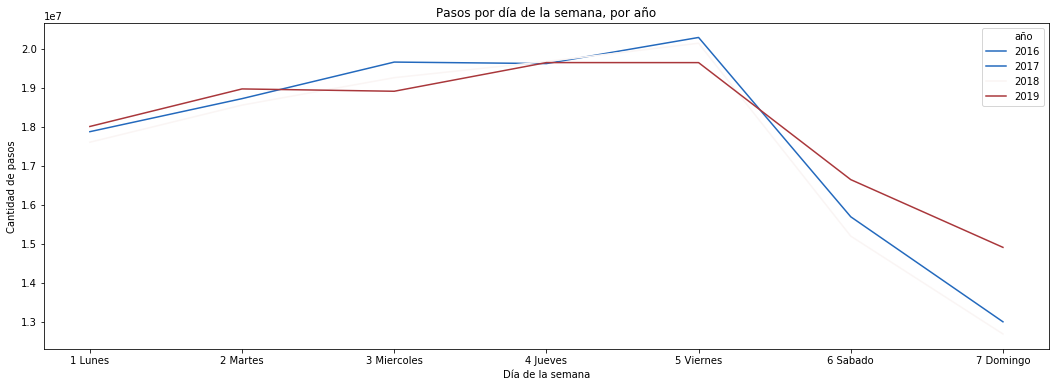

In [11]:
#Agrupamos el data set segun los días de semana

dia_sem = dataset.groupby(["año","dia_sem"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (18,6))

sns.lineplot(data = dia_sem, x = "dia_sem", y = "cantidad_pasos", hue = "año", palette = "vlag")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad de pasos")
plt.title("Pasos por día de la semana, por año")

El comportamiento del tráfico es similar en los 3 años, habiendo mayor cantidad de vehículos los dias jueves y viernes y se reduce el finde de semana. 

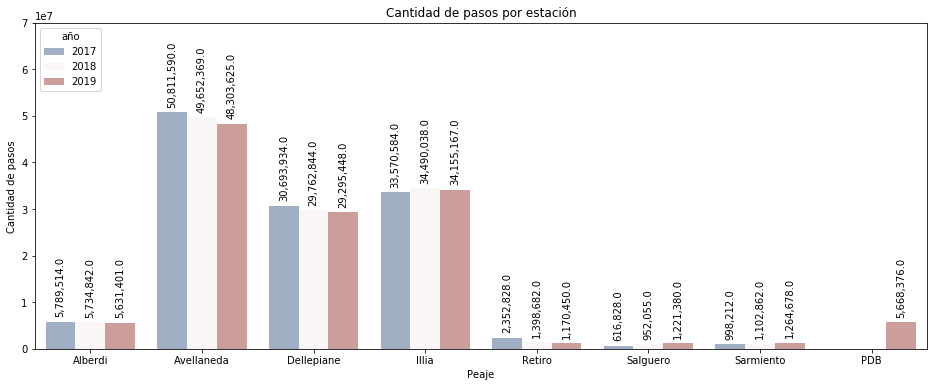

In [12]:
#Ya que ahora analizamos a todos los peajes, es preciso revisar como fue la distribución por año del transito de cada uno.

estaciones = dataset.groupby(["año","estacion"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (16,6))

barplt = sns.barplot(data = estaciones, x = "estacion", y = "cantidad_pasos", hue = "año", palette = "vlag")
plt.ylim(0, 70000000)
plt.xlabel("Peaje")
plt.ylabel("Cantidad de pasos")
plt.title("Cantidad de pasos por estación")

#Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    #Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)

Como se puede visualizar, las estaciones de peaje mas concurridas son Avellaneda, Dellepieane e Illia. Tanto en Avellaneda como Dellepiane el tránsito se ha disminuido en el tiempo en cambio en el 2018 en Illia presenta un aumento leve de la cantidad de pasos. Finalmente se oberva la incorporacion del Paseo Del Bajo en el 2019, el cual fue habilitado en dicho periodo.

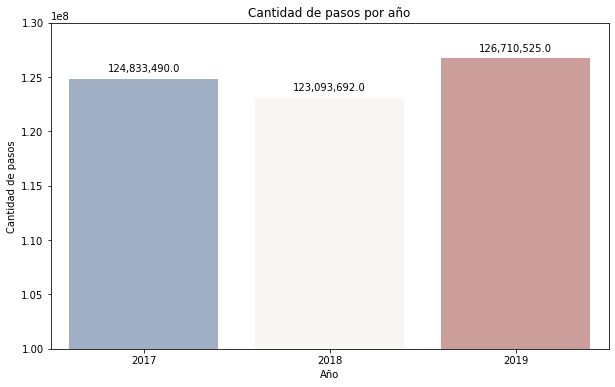

In [13]:
#Es conveniente revisar la cantidad de pasos en todas las estaciones por año.

pasos_años = dataset.groupby(["año"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (10,6))

barplt = sns.barplot(data = pasos_años, x = "año", y = "cantidad_pasos", palette = "vlag")
plt.ylim(100000000, 130000000)
plt.xlabel("Año")
plt.ylabel("Cantidad de pasos")
plt.title("Cantidad de pasos por año")

# Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    # Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     ha='center',
     va=va)
plt.show()

Como era de esperarse, el 2018 fue el periodo de menor tránsito de vehículos. Se puede ver el incremento en el 2019.

A continuación se realiza un analisis para responder a las 2 preguntas expuestas en la introducción:

1- ¿Cómo varían las formas de pago en todas las estaciones de peaje?

2- ¿Hay comportamientos de pago distintos si es día feriado o fines de semana?

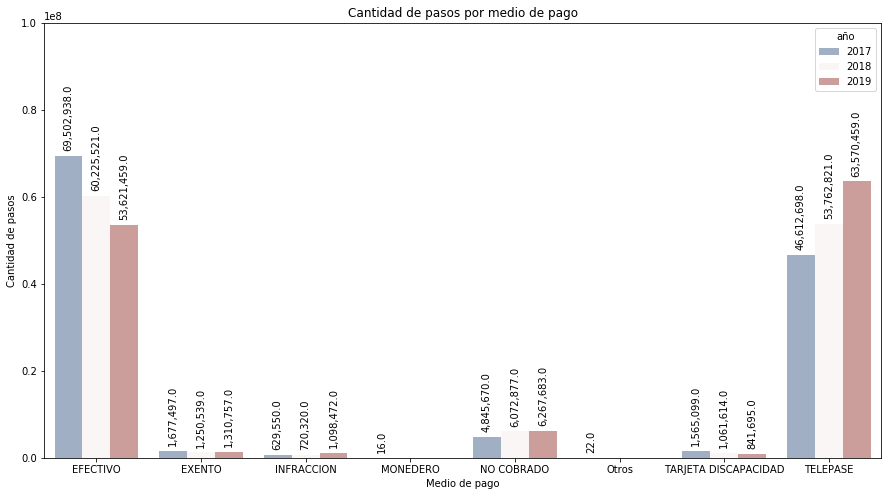

In [14]:
#Para la primer pregunta se agrupa por forma de pago

forma_pago = dataset.groupby(["año","forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (15,8))

barplt = sns.barplot(data = forma_pago, x = "forma_pago", y = "cantidad_pasos", hue = "año", palette = "vlag")
plt.ylim(0, 100000000)
plt.xlabel("Medio de pago")
plt.ylabel("Cantidad de pasos")
plt.title("Cantidad de pasos por medio de pago")

#Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    #Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

Los medios de pago mas representativos son EFECTIVO Y TELEPASE. También se puede confirmar que a medida que disminuye el uso del EFECTIVO aumenta el del TELEPASE a lo largo de los 3 años analizados. Esto puede deberse a las politicas de pago insentivadas por la empresa para estimular el uso de medios electrónicos o digitales.

In [15]:
#Se dejarán solo 4 valores en medio de pago: Efectivo, Telepase, No cobrado y Otros medios de pago
dataset = dataset.replace({"EXENTO":"Otras formas de pago",
                           "INFRACCION":"Otras formas de pago", 
                           "MONEDERO":"Otras formas de pago", 
                           "TARJETA DISCAPACIDAD":"Otras formas de pago", 
                           "Otros":"Otras formas de pago"})

#Lo mismo se realizará para las estaciones de peaje, dejando solo las 3 de mayor tránsito
dataset = dataset.replace({"Alberdi":"Resto",
                           "Retiro":"Resto", 
                           "Salguero":"Resto", 
                           "Sarmiento":"Resto", 
                           "PDB":"Resto"})

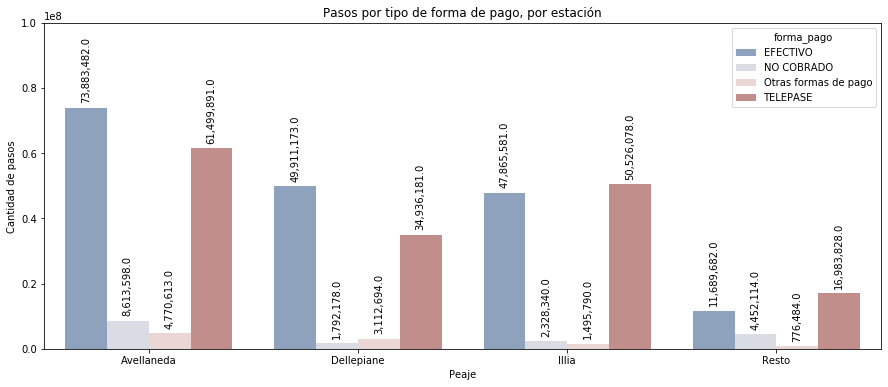

In [16]:
#Vamos a profundizar en el comportamiento de pago por estación de peaje

forma_pago_2 = dataset.groupby(["estacion","forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (15,6))

barplt = sns.barplot(data = forma_pago_2, x = "estacion", y = "cantidad_pasos", hue = "forma_pago", palette = "vlag")
plt.ylim(0, 100000000)
plt.xlabel("Peaje")
plt.ylabel("Cantidad de pasos")
plt.title("Pasos por tipo de forma de pago, por estación")

#Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    #Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

Como se observa en las estaciones Dellepiane y Avellaneda el uso de TELEPASE es mucho menor a EFECTIVO y en Illia y Resto se presenta lo contrario. De tomarse una medida para incentivar los medios digitales o electrónicos se tendrá que tener en cuenta esta situación, ya que probablemente el comportamiento de la comunidad a usar ciertos medios tenga que ver con características como el poder socio económico y conocimiento del manejo de este tipo de opciones.

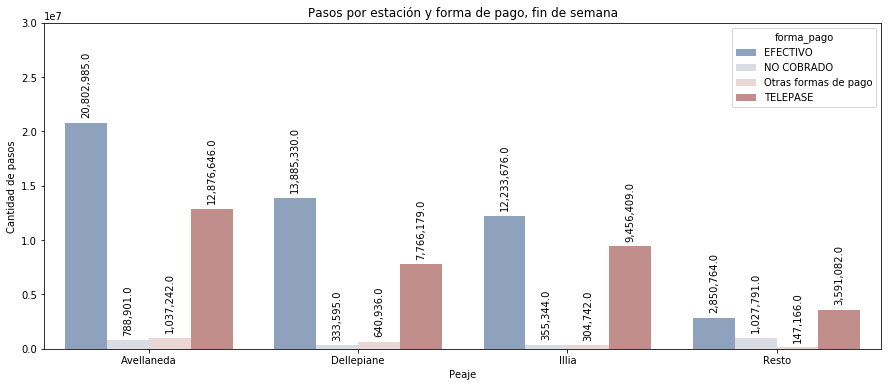

In [17]:
#Ahora ahondaremos en el comportamiento del fin de semana

mask = np.logical_or(dataset.dia_sem == '6 Sabado', dataset.dia_sem == '7 Domingo')
dataset_finde = dataset[mask]

fin_de_semana = dataset_finde.groupby(["estacion","forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

plt.figure(figsize = (15,6))

barplt = sns.barplot(data = fin_de_semana, x = "estacion", y = "cantidad_pasos", hue = "forma_pago", palette = "vlag")
plt.ylim(0, 30000000)
plt.xlabel("Peaje")
plt.ylabel("Cantidad de pasos")
plt.title("Pasos por estación y forma de pago, fin de semana")

#Poner etiquetas dentro del gráfico
coment=barplt.patches
for coment in coment :
    y_value = coment.get_height()
    x_value = coment.get_x() + coment.get_width()/2
    space = 5
    va = 'bottom'
    label = "{:,}".format(y_value)
    #Crear la anotación
    plt.annotate(
     label,
     (x_value, y_value),
     xytext=(0, space),
     textcoords="offset points",
     rotation = 'vertical',
     ha='center',
     va=va)
plt.show()

En los peajes Avellaneda, Dellepiane y Resto se nota el mismo comportamiento que el resto de los días excepto que en Illia presenta una disminución del TELEPASE a diferencia que de lunes a viernes este medio de pago incrementa. Esto puede responder a que Illia une el centro y el puerto de la Ciudad con la Gral. Paz. lo que facilita el acceso turístico que generalmente abona con EFECTIVO.

### Modelo de Machine Learning

Para comenzar con los modelos, preparamos la base a utilizar.

In [18]:
import datetime

#Importo el dataset
dataset = pd.read_csv('dataset_proyecto_final.csv', sep =',')

#Elimino las columnas que no necesito
dataset.drop(columns = ["Unnamed: 0","año","trimestre","mes","dia","hora"], inplace = True)

#Elimino la hora de la columna fecha
dataset['fecha2'] = pd.to_datetime(dataset.fecha).dt.date
dataset.drop(columns = ['fecha'], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True)

#Para simplificar la informacion agrupo por cada uno de los atributos
dataset = dataset.groupby(["fecha","dia_sem","estacion","sentido","tipo_vehiculo","forma_pago"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")
dataset

,fecha,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,EFECTIVO,2120
1,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,EXENTO,36
2,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,INFRACCION,1
3,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,NO COBRADO,34
4,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,TARJETA DISCAPACIDAD,68
...,...,...,...,...,...,...,...
121550,2019-12-31,2 Martes,Salguero,Provincia,Pesado,TELEPASE,31
121551,2019-12-31,2 Martes,Sarmiento,Provincia,Liviano,NO COBRADO,544
121552,2019-12-31,2 Martes,Sarmiento,Provincia,Liviano,TELEPASE,1591
121553,2019-12-31,2 Martes,Sarmiento,Provincia,Pesado,NO COBRADO,14


**Se incorpora una nueva variable que tiene en cuenta los días feriados, días no laborales y feriados puente con fin turístico. De esta forma el data set tendra identificado estos eventos, que en nuestros país pueden demostrar cambios en el comportamiento de la gente respecto al tráfico vehicular.**

Se agrega una columna con días feriados de los 3 años analizados.

In [19]:
feriados = pd.Series(['2017-01-01','2017-02-27','2017-02-28','2017-03-27','2017-04-02','2017-04-13','2017-04-14','2017-05-01','2017-05-25','2017-06-17','2017-06-19','2017-07-09','2017-08-21','2017-10-16','2017-11-20','2017-12-08','2017-12-25',
           '2018-01-01','2018-02-12','2018-02-13','2018-03-24','2018-03-29','2018-03-30','2018-04-02','2018-04-30','2018-05-01','2018-05-25','2018-06-17','2018-06-20','2018-07-09','2018-08-17','2018-10-12','2018-11-20','2018-12-08','2018-12-24','2018-12-25','2018-12-31',
           '2019-01-01','2019-03-04','2019-03-05','2019-03-24','2019-04-02','2019-04-19','2019-05-01','2019-05-25','2019-06-17','2019-06-20','2019-07-08','2019-07-09','2019-08-17','2019-08-19','2019-10-12','2019-10-14','2019-11-18','2019-12-08','2019-12-25'])

In [20]:
feriados_df = pd.DataFrame({'fecha_feriado': feriados})
feriados_df

,fecha_feriado
0,2017-01-01
1,2017-02-27
2,2017-02-28
3,2017-03-27
4,2017-04-02
5,2017-04-13
6,2017-04-14
7,2017-05-01
8,2017-05-25
9,2017-06-17


In [21]:
#Joineamos el dataset original con el dataframe de los feriados
dataset_total = pd.merge(dataset, feriados_df, how = 'left' # Importante: hacer un left join
                ,left_on = 'fecha' # si es que "fecha" es el nombre de la columna correspondiente en el dataframe "diario"
                ,right_on = 'fecha_feriado')

In [22]:
dataset_total.head()

,fecha,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha_feriado
0,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,EFECTIVO,2120,NaN
1,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,EXENTO,36,NaN
2,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,INFRACCION,1,NaN
3,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,NO COBRADO,34,NaN
4,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,TARJETA DISCAPACIDAD,68,NaN


In [23]:
#Ahora el dataframe diario tiene una columna extra que se llama "fecha_feriado"
#Esa columna esta en NULL/NaN si es que es una fecha normal/no feriado. 
#Creamos la columna binaria que nos dice si el dia en cuestion es feriado o no.
dataset_total.loc[dataset_total.fecha_feriado.isna(), 'es_feriado'] = 0
dataset_total.loc[~dataset_total.fecha_feriado.isna(), 'es_feriado'] = 1

In [24]:
#Se elimina la columna fecha_feriado porque ya no es necesaria
dataset_total.drop(columns = ['fecha_feriado'], inplace = True)
dataset_total.head()

,fecha,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,es_feriado
0,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,EFECTIVO,2120,0.0
1,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,EXENTO,36,0.0
2,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,INFRACCION,1,0.0
3,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,NO COBRADO,34,0.0
4,2017-01-01,7 Domingo,Alberdi,Centro,Liviano,TARJETA DISCAPACIDAD,68,0.0


**Modelo Benchmark - Regresión Lineal**

In [25]:
#Se resamplean los datos de manera diaria
diario = dataset_total.groupby(["fecha"])[("cantidad_pasos")].sum().reset_index(name="cantidad_pasos")

#Se realiza la Regresión Lineal
diario['fecha_numeros'] = diario.fecha.map(datetime.datetime.toordinal)
diario.set_index('fecha', inplace = True)

split_date = datetime.date(2019, 9, 30)

train_bench = diario.loc[diario.index <= split_date].copy()
test_bench  = diario.loc[diario.index >  split_date].copy()

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_bench.fecha_numeros.values.reshape(-1, 1), train_bench.cantidad_pasos)

LinearRegression()

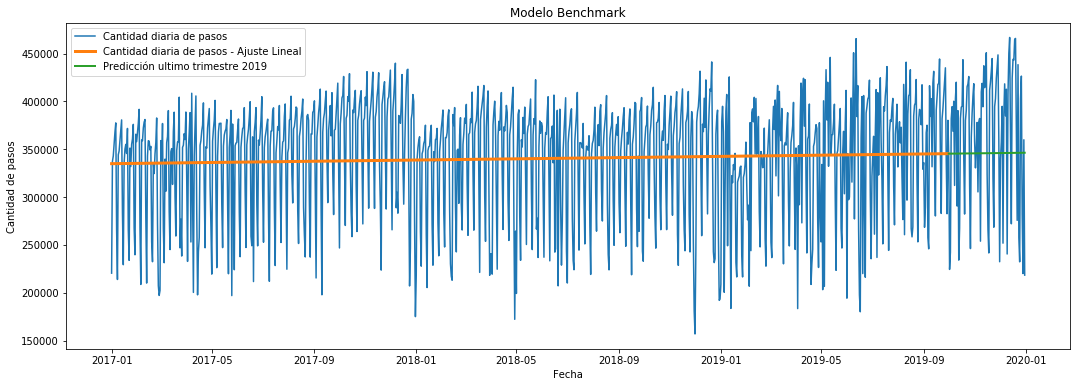

In [26]:
#Graficamos los datos originales, la regresión lineal y la predicción
plt.figure(figsize = (18,6))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de pasos')
plt.plot(train_bench.index, lr.predict(train_bench.fecha_numeros.values.reshape(-1, 1)), lw = 3, label = 'Cantidad diaria de pasos - Ajuste Lineal')
plt.plot(test_bench.index, lr.predict(test_bench.fecha_numeros.values.reshape(-1, 1)),  lw = 2, label = 'Predicción ultimo trimestre 2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.title("Modelo Benchmark")
plt.show()

In [27]:
#Calculamos el RMSE
from sklearn.metrics import mean_squared_error
rmse_bench = np.sqrt(mean_squared_error(test_bench.cantidad_pasos, lr.predict(test_bench.fecha_numeros.values.reshape(-1, 1))))
rmse_bench

72563.08030289183

El RMSE del Modelo Bench resulta mucho más elevado de los modelos probados en el proyecto 3, lo cierto es que esta nueva base integra a todas las estaciones durante los 3 periodos analizados lo que puede ser un condicionante. Ahora realizamos un Modelo de Árbol de Decisión y posteriormente optimizaremos hiperparámetros.

In [28]:
#Se dejan solo 4 valores en medio de pago: Efectivo, Telepase, No cobrado y Otros medios de pago
dataset_total = dataset_total.replace({"EXENTO":"Otros medios de pago",
                           "INFRACCION":"Otros medios de pago", 
                           "MONEDERO":"Otros medios de pago", 
                           "TARJETA DISCAPACIDAD":"Otros medios de pago", 
                           "Otros":"Otros medios de pago"})

#Lo mismo se realizará para las estaciones de peaje, dejando solo las 3 de mayor tránsito
dataset_total = dataset_total.replace({"Alberdi":"Resto peajes",
                           "Retiro":"Resto peajes", 
                           "Salguero":"Resto peajes", 
                           "Sarmiento":"Resto peajes", 
                           "PDB":"Resto peajes"})

#Se convierto en número la fecha para que no se vuelva una variable dummie
dataset_total['fecha_numeros'] = dataset_total.fecha.map(datetime.datetime.toordinal)
dataset_total = dataset_total.drop(columns = ["fecha"])
dataset_total

,dia_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,es_feriado,fecha_numeros
0,7 Domingo,Resto peajes,Centro,Liviano,EFECTIVO,2120,0.0,736330
1,7 Domingo,Resto peajes,Centro,Liviano,Otros medios de pago,36,0.0,736330
2,7 Domingo,Resto peajes,Centro,Liviano,Otros medios de pago,1,0.0,736330
3,7 Domingo,Resto peajes,Centro,Liviano,NO COBRADO,34,0.0,736330
4,7 Domingo,Resto peajes,Centro,Liviano,Otros medios de pago,68,0.0,736330
...,...,...,...,...,...,...,...,...
121550,2 Martes,Resto peajes,Provincia,Pesado,TELEPASE,31,0.0,737424
121551,2 Martes,Resto peajes,Provincia,Liviano,NO COBRADO,544,0.0,737424
121552,2 Martes,Resto peajes,Provincia,Liviano,TELEPASE,1591,0.0,737424
121553,2 Martes,Resto peajes,Provincia,Pesado,NO COBRADO,14,0.0,737424


Para usar las variables categóricas (dia_sem, estacion, sentido, tipo_vehiculo y forma_pago) es necesario convertir a dummies dichos campos.

In [29]:
#Se pasa a  variables dummies
dataset_total = pd.get_dummies(dataset_total)
dataset_total.head()

,cantidad_pasos,es_feriado,fecha_numeros,dia_sem_1 Lunes,dia_sem_2 Martes,dia_sem_3 Miercoles,dia_sem_4 Jueves,dia_sem_5 Viernes,dia_sem_6 Sabado,dia_sem_7 Domingo,...,estacion_Illia,estacion_Resto peajes,sentido_Centro,sentido_Provincia,tipo_vehiculo_Liviano,tipo_vehiculo_Pesado,forma_pago_EFECTIVO,forma_pago_NO COBRADO,forma_pago_Otros medios de pago,forma_pago_TELEPASE
0,2120,0.0,736330,0,0,0,0,0,0,1,...,0,1,1,0,1,0,1,0,0,0
1,36,0.0,736330,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0
2,1,0.0,736330,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0
3,34,0.0,736330,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,1,0,0
4,68,0.0,736330,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


In [30]:
#Se separa el dataset en Train y Test
split_date = datetime.date(2019, 9, 30)
split_date = split_date.toordinal()

train = dataset_total.loc[dataset_total.fecha_numeros <= split_date].copy()
test  = dataset_total.loc[dataset_total.fecha_numeros >  split_date].copy()

X_train_arbol = train.drop(columns = ["cantidad_pasos"])
X_test_arbol  = test.drop(columns = ["cantidad_pasos"])

y_train_arbol = train.cantidad_pasos
y_test_arbol  = test.cantidad_pasos

#Generamos el modelo de Arbol de Decisión
from sklearn.tree import DecisionTreeRegressor

arbol_model = DecisionTreeRegressor()
arbol_model.fit(X_train_arbol, y_train_arbol)

y_train_pred_arbol = arbol_model.predict(X_train_arbol)
y_test_pred_arbol  = arbol_model.predict(X_test_arbol)

RMSE Train modelo Árbol de Decisión: 502.3
RMSE Test modelo Árbol de Decisión: 1879.4


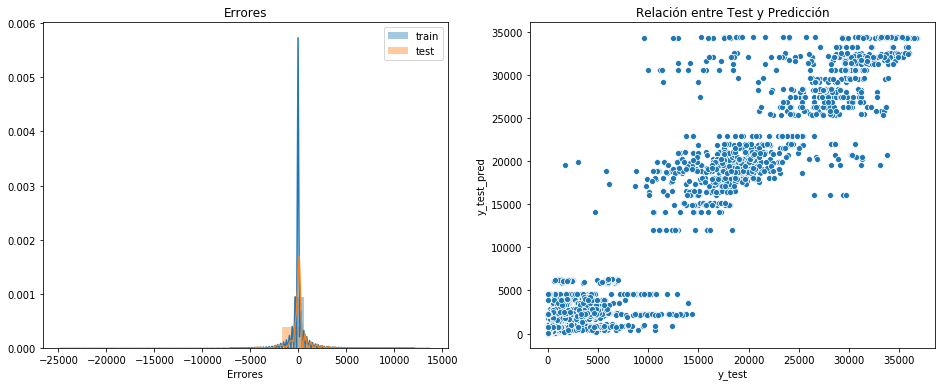

In [31]:
#Calculamos el RMSE
from sklearn.metrics import mean_squared_error
rmse_train_arbol = np.sqrt(mean_squared_error(y_train_arbol, y_train_pred_arbol))
rmse_test_arbol  = np.sqrt(mean_squared_error(y_test_arbol, y_test_pred_arbol))

print('RMSE Train modelo Árbol de Decisión: %.1f' % rmse_train_arbol)
print('RMSE Test modelo Árbol de Decisión: %.1f' % rmse_test_arbol)

#Gráficamos del error
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)

sns.distplot(y_train_arbol - y_train_pred_arbol, bins = 20, label = 'train')
sns.distplot(y_test_arbol - y_test_pred_arbol, bins = 20, label = 'test')
plt.xlabel('Errores')
plt.legend()
plt.title("Errores")

plt.subplot(1,2,2)

sns.scatterplot(y_test_arbol,y_test_pred_arbol)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.title("Relación entre Test y Predicción")

plt.show()

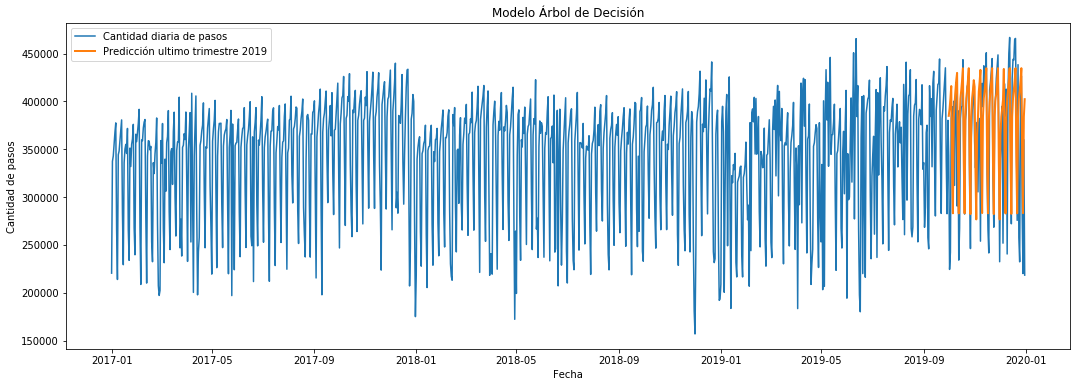

In [32]:
#Graficamos los datos originales y la predicción
plt.figure(figsize = (18,6))

test['fecha'] = test.fecha_numeros.map(datetime.datetime.fromordinal)
test['prediccion'] = y_test_pred_arbol

test = test.groupby(["fecha"])[("prediccion")].sum().reset_index(name="prediccion")

test.set_index('fecha', inplace = True)

plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de pasos')
plt.plot(test.index,  test.prediccion,  lw = 2, label = 'Predicción ultimo trimestre 2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.title("Modelo Árbol de Decisión")
plt.show()

El RMSE obtenido con el modelo de Árbol de Decisión, quedó muy por debajo del Modelo Bench y además por debajo del mejor RMSE obtenido en el proyecto 3 (5139.25). Lo que se visualiza también es que  hay un sobre ajuste del modelo. Continuamos con la optimización de hiperparámetros.

**Modelo Árbol de Decisión Optimizado**

In [33]:
#Grid Search para Árbol de Decisión
import time
start = time.time()

#Armamos la grilla
param_dist = {'min_samples_split' : np.arange(2,6),
              'min_samples_leaf'  : np.arange(1,5),
              'max_depth'         : np.arange(1,200)}

#Generamos el Árbol de Decisión
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()

#Grid Search
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(tree_model, param_grid = param_dist, cv=5)
model.fit(X_train_arbol, y_train_arbol)

end = time.time()
process_time = (end - start)

print("Mejores parametros: "+str(model.best_params_))

Mejores parametros: {'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 5}


In [34]:
# Tiempo de procesamiento del Grid Search
print('Tiempo de Procesamiento del Grid Search: %.1f' % process_time)

Tiempo de Procesamiento del Grid Search: 5358.0


In [35]:
#Separo X e Y
split_date = datetime.date(2019, 9, 30)
split_date = split_date.toordinal()

train_2 = dataset_total.loc[dataset_total.fecha_numeros <= split_date].copy()
test_2  = dataset_total.loc[dataset_total.fecha_numeros >  split_date].copy()

X_train_opt = train_2.drop(columns = ["cantidad_pasos"])
X_test_opt  = test_2.drop(columns = ["cantidad_pasos"])

y_train_opt = train_2.cantidad_pasos
y_test_opt  = test_2.cantidad_pasos

#Generamos el modelo con los mejores parámetros
from sklearn.tree import DecisionTreeRegressor
arbol_model_opt = DecisionTreeRegressor(max_depth = 11, min_samples_leaf = 3, min_samples_split = 4)
arbol_model_opt.fit(X_train_opt, y_train_opt)

y_train_pred_opt = arbol_model_opt.predict(X_train_opt)
y_test_pred_opt  = arbol_model_opt.predict(X_test_opt)

RMSE Train modelo Árbol de Decisión Optimizado: 1213.8
RMSE Test modelo Árbol de Decisión Optimizado: 1794.5


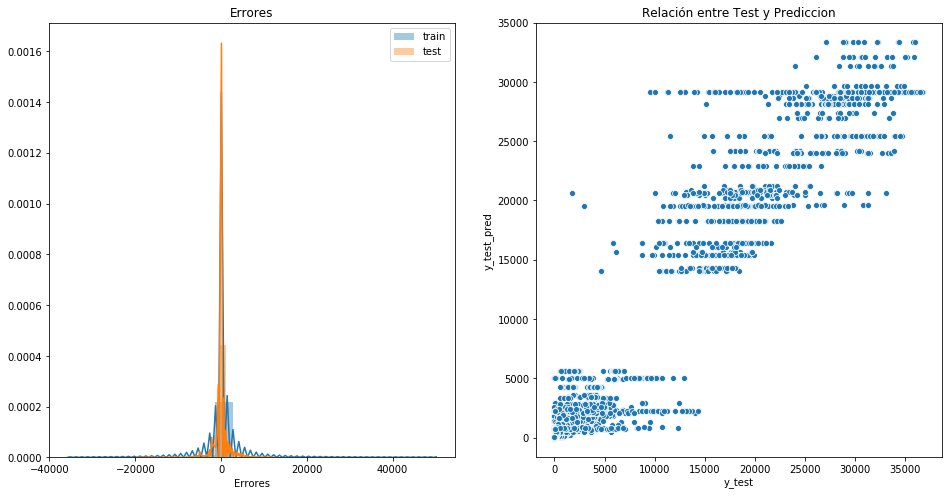

In [36]:
#Se calcula RMSE
from sklearn.metrics import mean_squared_error
rmse_train_opt = np.sqrt(mean_squared_error(y_train_opt, y_train_pred_opt))
rmse_test_opt  = np.sqrt(mean_squared_error(y_test_opt, y_test_pred_opt))

print('RMSE Train modelo Árbol de Decisión Optimizado: %.1f' % rmse_train_opt)
print('RMSE Test modelo Árbol de Decisión Optimizado: %.1f' % rmse_test_opt)

#Gráficamos del error
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)

sns.distplot(y_train_opt - y_train_pred_opt, bins = 20, label = 'train')
sns.distplot(y_test_opt - y_test_pred_opt, bins = 20, label = 'test')
plt.xlabel('Errores')
plt.legend()
plt.title('Errores')

plt.subplot(1,2,2)

sns.scatterplot(y_test_opt,y_test_pred_opt)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.title("Relación entre Test y Prediccion")

plt.show()

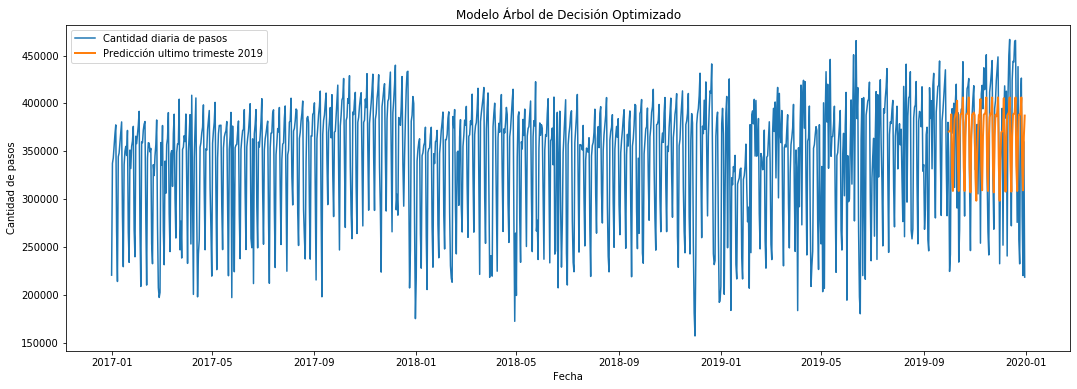

In [37]:
#Graficamos los datos originales y la predicción
plt.figure(figsize = (18,6))
test_2['fecha'] = test_2.fecha_numeros.map(datetime.datetime.fromordinal)
test_2['prediccion'] = y_test_pred_opt

test_2 = test_2.groupby(["fecha"])[("prediccion")].sum().reset_index(name="prediccion")

test_2.set_index('fecha', inplace = True)

plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad diaria de pasos')
plt.plot(test_2.index,  test_2.prediccion,  lw = 2, label = 'Predicción ultimo trimeste 2019')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.title("Modelo Árbol de Decisión Optimizado")
plt.show()

A través de la optimización de hiperparámetros se redujo el sobre ajuste, logrando mejor performance del modelo.

## Conclusiones

En el Proyecto 3 de Series de Tiempo se inició analizando la estación de Peaje Illia y se consideraron varios modelos predictivos, teniendo en cuenta solamente aquellos específicos de Series Temporales. El modelo que nos dió la mejor performance fue el SARIMAX Optimizando Hiperparámetros.

En este proyecto final se implementó lo que se anticipó en el Proyecto 3, probar con un modelo predictivo de Árbol de Decisión ya que este permite tener en cuenta otras variables por lo que se decidió incluir Feriados a la base y considerar aquellas variables categóricas que se encontraban en la base original a través de dummies. El mejor Modelo de Arbol de Decisión se logro con la optimización de hiperparámetros. Esto da cuenta de que al agregar nuevos atributos, estudiando previamente el caso a través de un análisis exploratorio de datos, se puede lograr un modelo mas adecuado a la necesidad planteada.

En cuanto a los resultados del modelo de Arbol de Decisión Optimizado, se considera haber llegado a un resultado óptimo para predecir el tráfico de las estaciones de peaje en el futuro. Un punto a tener en cuenta es el contexto ya que las circunstancias pueden inlfluir en la interpretación de los resultados, como pasó con el surgimiento de la Pandemia de COVID19 durante el 2020. Finalmente, es muy importante conocer y comprender el negocio y ademas las herramientas disponibles para realizar los modelos predictivos, ya que la combinación de todos estos aspectos influiran en las decisiones finales.



**Git Hub**